## Loading Packages

In [182]:
from fbprophet import Prophet
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from utils import *
import warnings

# plt.style.use('dark_background')
warnings.filterwarnings("ignore")

## Loading Data

In [183]:
def universe_select(path, commodity_name):
    """Selects the instruments believed to be of
    interest for the commodity selected
    Returns: A dictionary of dataframes which are
    intruments of interest"""
    universe_dict = {}
    
    if commodity_name == "Al": 
        aluminium_list = ["al_shfe", "al_lme", "al_comex_p", "al_comex_s", "al_lme_s", "yuan",
                 "bdi", "ted", "vix", "skew", "gsci"]
        
        for instrument in aluminium_list:
            df = pd.read_csv(path + instrument + ".csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
            universe_dict[instrument] = df
            
    elif commodity_name == "Cu":
        copper_list = ["cu_shfe", "cu_lme", "cu_comex_p", "cu_comex_s", "peso", "sol",
                 "bdi", "ted", "vix", "skew", "gsci"]
        
        for instrument in copper_list:
            df = pd.read_csv(path + instrument + ".csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
            universe_dict[instrument] = df
    
    else: print("Select an appropriate commodity")
    return universe_dict


In [184]:
path = "Data/"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [185]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)
# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)
# Making sure that all the points in the window have consistent lenght
universe_dict = truncate_window_length(universe_dict)
# Add log returns columns
universe_dict = generate_lg_returns(universe_dict)
print()
# Generate the full training dataset
df_full = generate_dataset(universe_dict, lg_returns_only=False)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci



In [186]:
# Visualise the plots
# visualise_universe(universe_dict)

# Choosing whether to focus on price of log returns
df = df_full[["price_cu_shfe"]]
# df = df_full["lg_return_cu_lme"]

In [8]:
# print(df_full.head())
# print(df.head())

## Additive Model

In [ ]:
def create_prophet_dataset(df):
    """Creates a dataframe that has data in the 
    format that works with facebooks additive 
    modelling software: fbprophet"""
    d = {"ds":df.index, "y":df}
    df = pd.DataFrame(data=d)
    df.reset_index(inplace=True)
    df = df.drop('date', 1)
    return df


def prophet_prediction(df, train_percentage=0.75):
    """Returns a dataframe of out of sample predictions
    trained on a growing percentage of available training data
    """
    # The prediction offset in business days
    week_diff = 5
    month_diff = 22
    quarter_diff = 66

    # The split index is the training percentage but adjusted so 
    # the first prediction date lands on the first date of the test set
    split_index_train = int(train_percentage * len(df)) - quarter_diff
    split_index_test = int(train_percentage * len(df))

    # The date that the test database will begin on
    split_date_test = df["ds"].iloc[split_index_test]
    
    # Creating the test set - This will remain constant
    # even though the training dataset will grow
    # The window size will not be constant 
    df_test = df.loc[df["ds"] >= split_date_test].copy()
    # Making df columns for the predicted values
    df_test["y_pred_week"] = None
    df_test["y_pred_month"] = None
    df_test["y_pred_quarter"] = None
    
    for offset in range(1): #len(df_test.index)
        print("Percentage Complete:", 100* offset/len(df_test.index))
        # Gradually increasing training dataset
        split_date_train = df["ds"].iloc[split_index_train + offset]
        # Creating the training set
        df_train = df.loc[df["ds"] <= split_date_train].copy()

        # Fitting the model
        model = Prophet(daily_seasonality=True)
        # Fit the data to the dataset
        model.fit(df_train)
        
        # Make predictions
        # Starting at the beginning of the test dataset there should be
        # week prediction, month, prediction and quarter prediction
        week_pred_date = df[df.index == [df_train.index[-1] + week_diff]]
        month_pred_date = df[df.index == [df_train.index[-1] + month_diff]]
        quarter_pred_date = df[df.index == [df_train.index[-1] + quarter_diff]]

        week_pred = model.predict(week_pred_date)[["ds", "yhat"]]
        month_pred = model.predict(month_pred_date)[["ds", "yhat"]]
        quarter_pred_date = model.predict(quarter_pred_date)[["ds", "yhat"]]
        # Finding the location in df_test with the date that 
        # we want to fill and setting the predicted value equal to the prediction
        df_test.loc[df_test['ds'] == week_pred.iloc[0]["ds"], 'y_pred_week'] = week_pred["yhat"].values[0]
        df_test.loc[df_test['ds'] == month_pred.iloc[0]["ds"], 'y_pred_month'] = month_pred["yhat"].values[0]
        df_test.loc[df_test['ds'] == quarter_pred_date.iloc[0]["ds"], 'y_pred_quarter'] = quarter_pred_date["yhat"].values[0]
        
    # Renaming the columns
    df_test.rename(columns={'y':"y_true"}, inplace=True)
    return df_test

In [ ]:
df = create_prophet_dataset(df_full["price_cu_lme"])

## Demonstration of how one training cycle works
This was done on price instead of log returns because it is more easily visualised

In [47]:
# Create the dataframe in a format that works with prophet
df = create_prophet_dataset(df_full["price_cu_lme"])
model = Prophet(daily_seasonality=True)
# The percentage of the data used for training
train_percentage = 0.6
# Convert string to timestamp
split_date = df["ds"].iloc[int(train_percentage * len(df))]
# Creating the training set
df_train = df.loc[df["ds"] <= split_date].copy()
# Creating the test set
df_test = df.loc[df["ds"] > split_date].copy()

In [48]:
model.fit(df_train)
# Join the forecast on ds
forecast = model.predict(df_test.reset_index()[["ds"]])[["ds", "yhat"]]

In [49]:
df_test = pd.merge(df_test, forecast, on="ds")

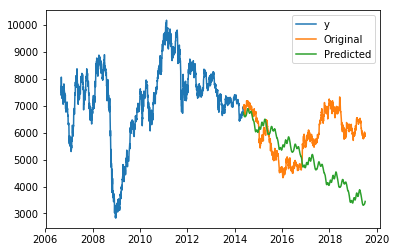

In [50]:
plt.plot(df_train["ds"], df_train["y"])
plt.plot(df_test["ds"], df_test["y"], label="Original")
plt.plot(df_test["ds"], df_test["yhat"], label="Predicted")
plt.legend()
plt.show()

#### As can be seen. The model is initially quite accurate with the inaccuracy increasing over time
As the predictions are made at 1 week, 1 month and 1 quarter it is hoped that the inaccuracy won't grow continuously 

In [201]:
# model.plot_components(forecast)

## Inverse Lg Returns Experimentation

In [187]:
df["lg_return_new"] = np.log(df.price_cu_shfe) - np.log(df.price_cu_shfe.shift(1)) 
df["lg_return"] = df_full["lg_return_cu_shfe"]
df["lg_return_diff"] = df["lg_return"] - df["lg_return_new"]

In [188]:
# print(df.price_cu_shfe)
# print(df.price_cu_shfe.shift(1))

In [189]:
df.head()
# print(df[df["lg_return_diff"]!=0])
# plt.plot(df.index, df.lg_return_diff)

,price_cu_shfe,lg_return_new,lg_return,lg_return_diff
date,,,,
2006-08-29,68160.0,NaN,0.000000,NaN
2006-08-30,67650.0,-0.007511,-0.007511,0.0
2006-08-31,67630.0,-0.000296,-0.000296,0.0
2006-09-01,70140.0,0.036442,0.036442,0.0
2006-09-04,71240.0,0.015561,0.015561,0.0


In [168]:
# Price[t] = np.exp(lg_return) * Price[t-1]
np.exp(-0.00751) * 68160

67650.03571273283

In [192]:
df_price = df[["price_cu_shfe"]]
df_lg = df[["lg_return"]]

In [193]:
df_lg.values[1:]

array([[-0.00751053],
       [-0.00029568],
       [ 0.03644157],
       ...,
       [-0.00710215],
       [ 0.0021575 ],
       [-0.00172563]])

In [195]:
factor = np.exp(np.roll(df_lg.values, -1))
inv_prices = [df_price.iloc[0].values[0]]

for i in range(len(factor) - 1):
    inv_prices.append(factor[i] * inv_prices[-1])


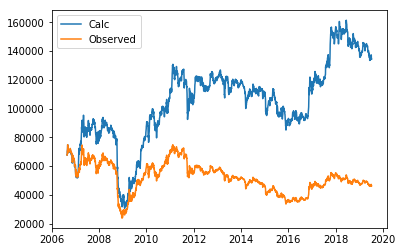

In [200]:
plt.plot(df.index[1:], inv_prices[1:], label="Calc")
plt.plot(df.index[1:], df["price_cu_shfe"][1:], label="Observed")
plt.legend()
plt.show()

In [163]:
out = factor.shift(-1).mul(price, axis=0)